In [80]:
# import lib
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dropout

from keras.models import save_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import joblib

import pandas as pd
import numpy as np
import pickle

In [4]:
df = pd.read_csv("data.csv")
df.set_index("date")

,price,warehouse_capacity,truck_capacity
date,,,
2024-01-01,85.95,61,46
2024-01-02,47.25,79,57
2024-01-03,23.61,59,68
2024-01-04,38.60,57,66
2024-01-05,38.55,61,52
...,...,...,...
2024-04-05,29.90,79,44
2024-04-06,2.71,64,56
2024-04-07,43.20,80,46


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               100 non-null    float64
 1   warehouse_capacity  100 non-null    int64  
 2   truck_capacity      100 non-null    int64  
 3   date                100 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ KB


In [6]:
sc = MinMaxScaler(feature_range=(0, 1))

In [7]:
df_scaled = sc.fit_transform(df[['price', 'warehouse_capacity', 'truck_capacity']])

In [8]:
df.info

<bound method DataFrame.info of     price  warehouse_capacity  truck_capacity        date
0   85.95                  61              46  2024-01-01
1   47.25                  79              57  2024-01-02
2   23.61                  59              68  2024-01-03
3   38.60                  57              66  2024-01-04
4   38.55                  61              52  2024-01-05
..    ...                 ...             ...         ...
95  29.90                  79              44  2024-04-05
96   2.71                  64              56  2024-04-06
97  43.20                  80              46  2024-04-07
98  49.39                  75              58  2024-04-08
99  61.31                  79              64  2024-04-09

[100 rows x 4 columns]>

In [9]:
windows = 14
X_train = []
y_train = []

In [11]:
for i in range(windows, len(df)):
    X_train.append(df_scaled[i - windows:i])
    y_train.append(df_scaled[i])

In [13]:
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(86, 14, 3)
(86, 3)


In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [46]:
def LSTM_model():
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=64
    model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=128
    model.add(LSTM(units = layer_2_units))
    model.add(Dropout(0.2))
    
    # Adding the output layer
    model.add(Dense(units = y_train.shape[1]))
    
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

In [65]:
model_LSTM = LSTM_model()

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [54]:
# Fitting the RNN to the Training set
epoch_no=64
batch_size=44
history = model_LSTM.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size, callbacks=[early_stopping],
                         validation_data=(X_val, y_val))

Epoch 1/64
2/2 [==============================] - 2s 479ms/step - loss: 0.3483 - val_loss: 0.1968
Epoch 2/64
2/2 [==============================] - 0s 30ms/step - loss: 0.1993 - val_loss: 0.0995
Epoch 3/64
2/2 [==============================] - 0s 31ms/step - loss: 0.1113 - val_loss: 0.1089
Epoch 4/64
2/2 [==============================] - 0s 33ms/step - loss: 0.1171 - val_loss: 0.1158
Epoch 5/64
2/2 [==============================] - 0s 31ms/step - loss: 0.1147 - val_loss: 0.0847
Epoch 6/64
2/2 [==============================] - 0s 31ms/step - loss: 0.0981 - val_loss: 0.0804
Epoch 7/64
2/2 [==============================] - 0s 28ms/step - loss: 0.0976 - val_loss: 0.0884
Epoch 8/64
2/2 [==============================] - 0s 30ms/step - loss: 0.1068 - val_loss: 0.0908
Epoch 9/64
2/2 [==============================] - 0s 27ms/step - loss: 0.1086 - val_loss: 0.0878
Epoch 10/64
2/2 [==============================] - 0s 27ms/step - loss: 0.0999 - val_loss: 0.0836
Epoch 11/64
2/2 [===========

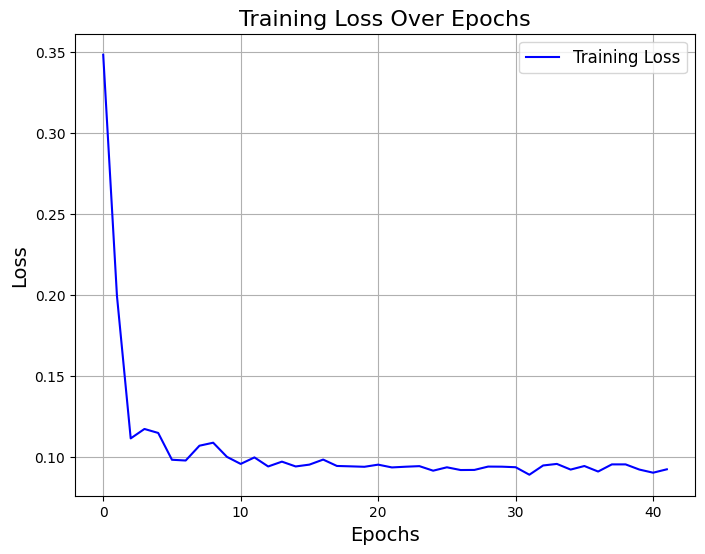

In [55]:
train_loss = history.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [61]:
def RNN_model():
    model = Sequential()
    
    # Adding the first RNN layer and some Dropout regularisation
    layer_1_units = 50
    model.add(SimpleRNN(units=layer_1_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    # Adding a second RNN layer and some Dropout regularisation
    layer_2_units = 400
    model.add(SimpleRNN(units=layer_2_units))
    model.add(Dropout(0.2))
    
    # Adding the output layer
    model.add(Dense(units=y_train.shape[1]))
    
    # Compiling the RNN
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [62]:
def GRU_model():
    model = Sequential()
    
    # Adding the first GRU layer and some Dropout regularisation
    layer_1_units = 50
    model.add(GRU(units=layer_1_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    # Adding a second GRU layer and some Dropout regularisation
    layer_2_units = 400
    model.add(GRU(units=layer_2_units))
    model.add(Dropout(0.2))
    
    # Adding the output layer
    model.add(Dense(units=y_train.shape[1]))
    
    # Compiling the GRU
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [70]:
model_rnn = RNN_model()
history = model_rnn.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size, callbacks=[early_stopping],
                         validation_data=(X_val, y_val))

Epoch 1/64
2/2 [==============================] - 1s 189ms/step - loss: 1.7751 - val_loss: 0.9498
Epoch 2/64
2/2 [==============================] - 0s 32ms/step - loss: 0.6491 - val_loss: 0.6157
Epoch 3/64
2/2 [==============================] - 0s 28ms/step - loss: 0.6301 - val_loss: 0.2074
Epoch 4/64
2/2 [==============================] - 0s 30ms/step - loss: 0.3362 - val_loss: 0.2951
Epoch 5/64
2/2 [==============================] - 0s 25ms/step - loss: 0.2730 - val_loss: 0.4824
Epoch 6/64
2/2 [==============================] - 0s 27ms/step - loss: 0.2684 - val_loss: 0.2792
Epoch 7/64
2/2 [==============================] - 0s 25ms/step - loss: 0.2175 - val_loss: 0.2192
Epoch 8/64
2/2 [==============================] - 0s 26ms/step - loss: 0.2281 - val_loss: 0.2507
Epoch 9/64
2/2 [==============================] - 0s 26ms/step - loss: 0.2212 - val_loss: 0.2380
Epoch 10/64
2/2 [==============================] - 0s 24ms/step - loss: 0.1500 - val_loss: 0.2514
Epoch 11/64
2/2 [===========

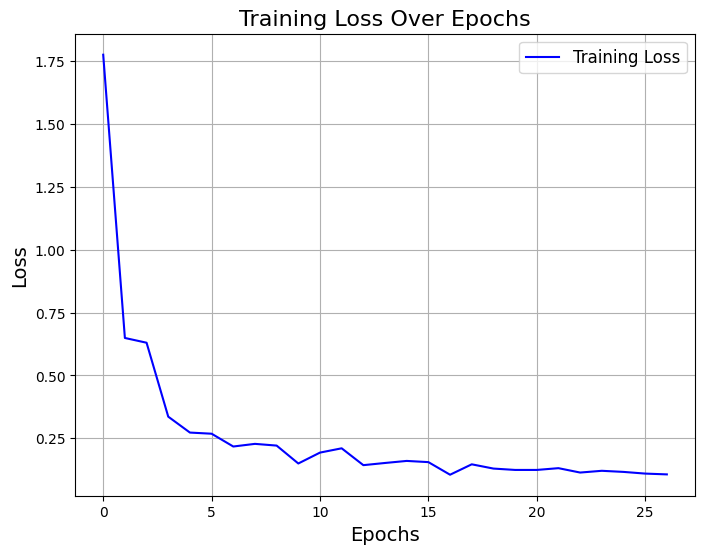

In [71]:
train_loss = history.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [74]:
model_gru = GRU_model()
history = model_gru.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size, callbacks=[early_stopping],
                         validation_data=(X_val, y_val))

Epoch 1/64
2/2 [==============================] - 3s 422ms/step - loss: 0.2897 - val_loss: 0.1076
Epoch 2/64
2/2 [==============================] - 0s 49ms/step - loss: 0.1106 - val_loss: 0.1273
Epoch 3/64
2/2 [==============================] - 0s 44ms/step - loss: 0.1347 - val_loss: 0.0908
Epoch 4/64
2/2 [==============================] - 0s 47ms/step - loss: 0.1062 - val_loss: 0.0850
Epoch 5/64
2/2 [==============================] - 0s 49ms/step - loss: 0.1010 - val_loss: 0.0994
Epoch 6/64
2/2 [==============================] - 0s 46ms/step - loss: 0.1094 - val_loss: 0.1037
Epoch 7/64
2/2 [==============================] - 0s 48ms/step - loss: 0.1074 - val_loss: 0.0984
Epoch 8/64
2/2 [==============================] - 0s 44ms/step - loss: 0.1029 - val_loss: 0.0913
Epoch 9/64
2/2 [==============================] - 0s 47ms/step - loss: 0.0986 - val_loss: 0.0867
Epoch 10/64
2/2 [==============================] - 0s 49ms/step - loss: 0.0934 - val_loss: 0.0862
Epoch 11/64
2/2 [===========

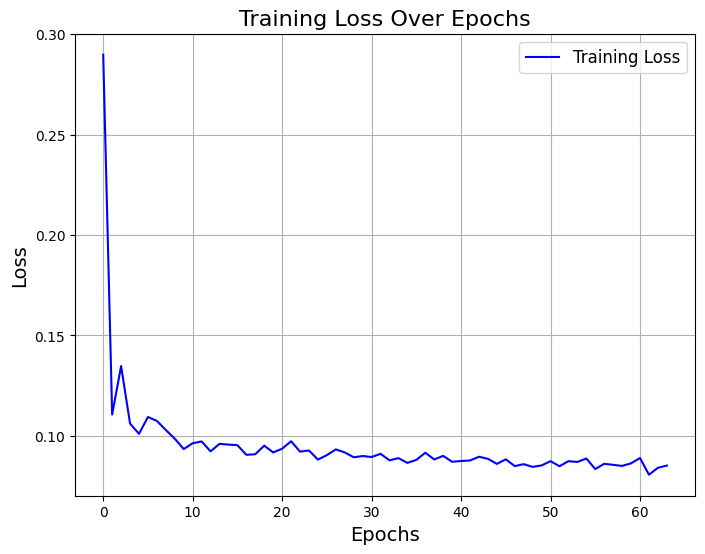

In [75]:
train_loss = history.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [76]:
# save_model
model_LSTM.save('./model_lstm.h5')
model_rnn.save('./model_rnn.h5')
model_gru.save('./model_gru.h5')

/home/long.vk@citigo.id/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [83]:
joblib.dump(sc, 'scaler.pkl')

['scaler.pkl']

In [84]:
type(sc)

sklearn.preprocessing._data.MinMaxScaler